# Web Scraping Project (Selenium/BeautifulSoup): Fantasy Formula 1 League 

Here is a little side project where I experiment with web scraping. (Without using an API!)

As a test I want to better visualise the progression of my Fantasy Formula 1 league which can be found here:
https://fantasy.formula1.com/leaderboards/league?league_id=15765 

The website gives a running total and race-by-race points (which are found after logging in) but there are no graphs to better understand this data. 

I will use Selenium to navigate the JavaScript elements of the site and BeautifulSoup to scrape the data from the html.

In [1]:
# First off some dependencies

# config file for log-in/password
import config as cfg

# For numerics and data tables
import numpy as np
import pandas as pd
# time is used to wait for pages to load
import time

# Selenium and BeautifulSoup are for web scraping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

# This is set up for Selenium. 
options = webdriver.ChromeOptions()
options.add_argument('headless')
capa = DesiredCapabilities.CHROME
capa["pageLoadStrategy"] = "none"

# This requires a webdriver which can be downloaded here: https://sites.google.com/a/chromium.org/chromedriver/home 
# The executable_path below must point to the location of the driver on your machine. 

## For me:
# home laptop
# driver = webdriver.Chrome(executable_path = r'C:\Users\Jacob\Downloads\chromedriver_win32 (1)\chromedriver.exe')
# work laptop
driver = webdriver.Chrome(executable_path = r'C:\Users\Jacob\Downloads\chromedriver_win32 (1)\chromedriver.exe')

driver.implicitly_wait(15)
driver.set_window_size(1440,900)


In [2]:
# Now we're ready to open the webpage
driver.get('https://fantasy.formula1.com/leaderboards/league?league_id=15765')

## Navigating the web with Selenium

To get to data on different web pages we can use Selenium to navigate between them.

In [3]:
# Click log-in button to navigate to log in page
driver.find_element_by_id('ember14').click()

Navigating the web requires inspecting elements on the web page to find how different parts of a page are labelled in the html (e.g. above the log-in button was identified by the id: 'ember11').

In [4]:
# Click log in button to get rid of cookies consent button
driver.find_element_by_id('truste-consent-button').click()

In [6]:
# Enter email address
driver.find_element_by_class_name('txtLogin').send_keys(cfg.email)
# Enter password (FYI this is not my password for any other accounts so don't bother trying!)
driver.find_element_by_class_name('txtPassword').send_keys(cfg.password)

# I probably should have set up a dummy email account for this...

In [7]:
# Click log in button to log in
driver.find_element_by_class_name('btn-primary').click()

## Scraping data with BeautifulSoup

Now we're at a page where we can scrape our first data point!: How many races have there been so far. 

In [8]:
# Pass the page to BeautifulSoup
soup_level1 = BeautifulSoup(driver.page_source, 'lxml')

# Find the table of previous races
# Again this relies on inspecting elements in the web page to find how they are identified.
race_table = soup_level1.find_all("ul", class_ = "dropdown-menu", attrs={"aria-labelledby": "dropdownMenu1"})[0]

# Find the number of races so far
# This is the 3rd element in the list.
N_races_so_far = int(race_table.contents[3]['class'][0])
print('There have been ' + str(N_races_so_far) + ' races so far.')

There have been 13 races so far.


Now to get the race-by-race points data. We will store the data in a pandas dataframe.

In [9]:
# First of all here is some stuff we already know
players = ['Jacob', 'Victoria', 'Zach', 'Ollie', 'Josh', 'Thomas', 'Jakob', 'Finley', 'Harry']
team_names = ['Formula Lang', 'Quick off the Clark', 'Cararri', 'Dead Bull', 'Chicane Shires', 'Turbo Tom', 'Brexit Legends', 'The flying Fin', 'HLF1']
num_players = len(players)
races = ['Australia', 'Bahrain', 'China', 'Azerbaijan', 'Spain', 'Monaco','Canada', 'France', 'Austria', 'Great Britian', 'Germany', 'Hungary', 'Belgium', 'Italy', 'Singapore', 'Russia', 'Japan', 'Mexico', 'USA', 'Brazil', 'Abu Dhabi']

# Create an empty pandas dataframe
index = races[:N_races_so_far]
columns =  players
df = pd.DataFrame(index = index, columns = columns)

In [10]:
# Loop through the races so far
for n_race in range(N_races_so_far):
    
    # Again we navigate with Selenium
    # Open dropdown menu
    python_button = driver.find_element_by_id('dropdownMenu1')
    python_button.click()
    # Open n'th race stats.
    x_path = "//li[@class='" + str(n_race + 1) +  "']"
    python_button = driver.find_element_by_xpath(x_path)
    python_button.click()
    
    # Allow time for page to load
    # 0.25 seconds seems to be enough but it may need to change for a slower internet connection. 
    time.sleep(1)
    
    # Scrape the data with BeautifulSoup
    soup_level2 = BeautifulSoup(driver.page_source, 'lxml')
    
    table = soup_level2.findAll("li", class_ = "list-row")
    
    for row in table:
        # This is where the player name is found
        name = row.findAll("span")[1].div.text[7:-1]
        # This is where the players points for that race are found
        points = int(row.findAll("span")[4].text.split('\n')[2])
        
        # Fill in the pandas dataframe
        df.loc[races[n_race], name] = points

# Harry joined after the 3rd race so we give him 100 points for each of those races so that he can join in. 
df.loc[['Australia', 'Bahrain', 'China'], 'Harry'] = 100

# Display the data
df

,Jacob,Victoria,Zach,Ollie,Josh,Thomas,Jakob,Finley,Harry
Australia,174,141,141,140,124,96,162,72,100
Bahrain,130,146,93,151,136,83,102,101,100
China,101,139,124,147,103,148,97,121,100
Azerbaijan,155,118,156,74,131,158,105,140,136
Spain,174,168,140,173,184,179,164,130,158
Monaco,135,122,174,172,133,133,131,165,138
Canada,129,134,134,131,131,126,142,150,143
France,171,189,180,125,193,193,117,152,162
Austria,207,175,149,170,176,159,127,161,124
Great Britian,136,205,236,148,190,204,122,189,231


So there you have it! The Fantasy Formula 1 league data... now in a handy pandas dataframe!

## Visualising the data

Let's plot some graphs!

First just the race-by-race points.

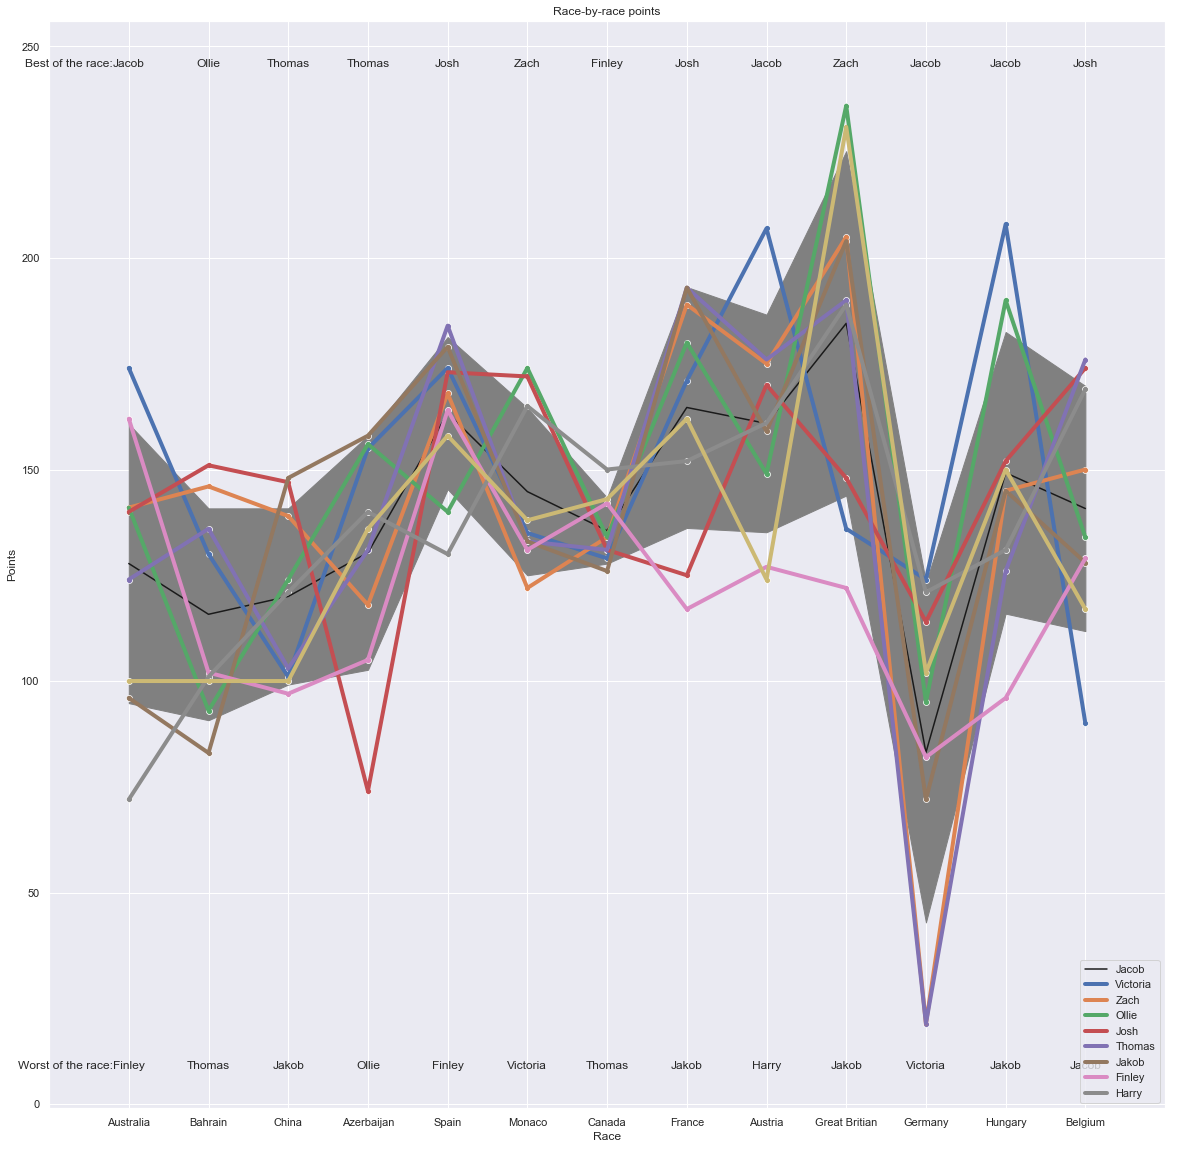

In [13]:
# Some more dependencies for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# mean and standard deviation
plt.plot(index, df.mean(axis=1), color = 'k')
y1 = df.mean(axis=1) + df.std(axis=1)
y2 = df.mean(axis=1) - df.std(axis=1)
plt.fill_between(index, y1, y2, color='gray')

# For each player
for col in df:
#     Plot their points per race.
    plt.plot(index, df[col], linewidth=4)
    sb.scatterplot(index, df[col])
    


# Add a legend and adjust figure size
plt.legend(players, loc='lower right')
fig = plt.gcf()
fig.set_size_inches(20,20)

# Title
plt.title('Race-by-race points')
# Set x-axis label
plt.xlabel('Race')
# Set y-axis label
plt.ylabel('Points')

# Axes limits
plt.xlim([-1, N_races_so_far])
min_points = df.min().min()
max_points = df.max().max()
plt.ylim([min_points - 20 , max_points + 20])

# Plot labels

# Best of the race
plt.gca().text(-0.2,max_points + 10, 'Best of the race:', horizontalalignment = 'right', verticalalignment='center')
best = df.idxmax(axis=1)
for n in range(N_races_so_far):
    plt.gca().text(n, max_points + 10, best[n], horizontalalignment = 'center', verticalalignment='center')
    
# Worst of the race
plt.gca().text(-0.2,min_points - 10, 'Worst of the race:', horizontalalignment = 'right', verticalalignment='center')
worst = df.idxmin(axis=1)
for n in range(N_races_so_far):
    plt.gca().text(n, min_points - 10, worst[n], horizontalalignment = 'center', verticalalignment='center')

Next I'll plot the difference from the mean:

Text(0, 0.5, 'Points')

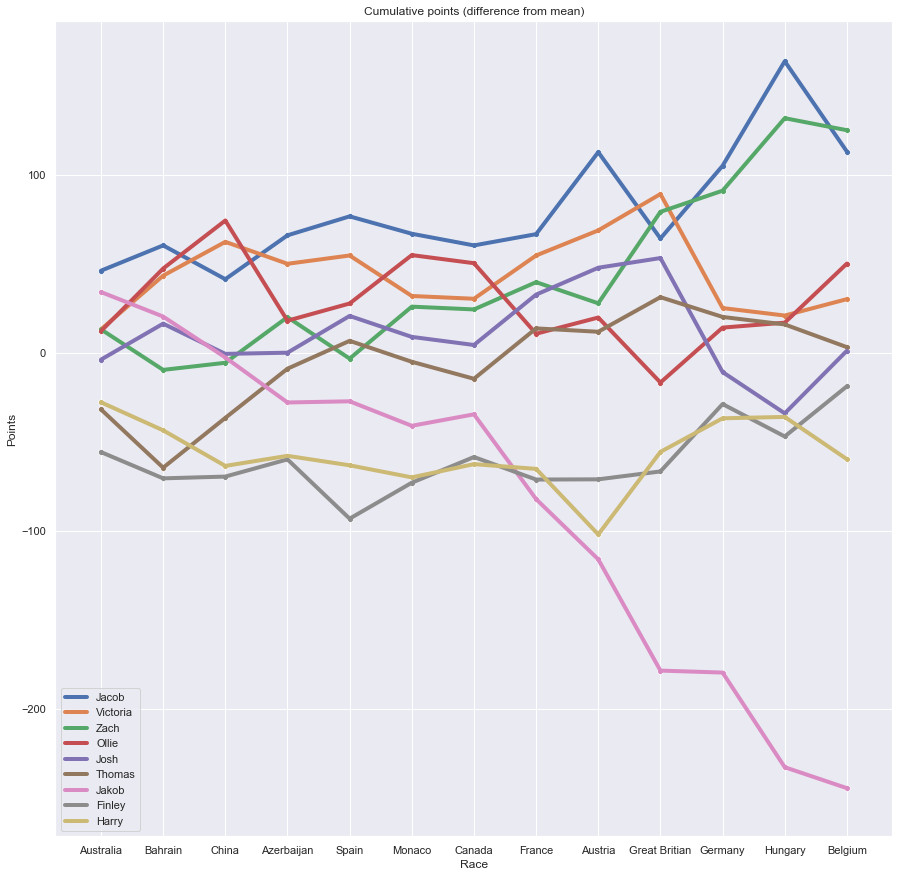

In [12]:
# Make of copy of the dataframe
df2 = df.copy()
# accumlate points
import itertools
for player in players:
    points_by_race = df2.loc[:, player].values
    df2.loc[:, player] = list(itertools.accumulate(points_by_race))
    

# For each player
for col in df:
#     Plot their points per race.
    plt.plot(index, df2[col] - df2.mean(axis=1), linewidth=4)
    sb.scatterplot(index, df2[col] - df2.mean(axis=1))

# Add a legend and adjust figure size
plt.legend(players, loc='lower left')
fig = plt.gcf()
fig.set_size_inches(15,15)

# Title
plt.title('Cumulative points (difference from mean)')
# Set x-axis label
plt.xlabel('Race')
# Set y-axis label
plt.ylabel('Points')

Now we can better visualise the perfomance of the players throughout the league.